# Lab 2 Aprendizaje profundo

## Integrantes

* Alvarez Lupu, Gustavo
* Ambrosis, Nicolás
* Conrrero, Agustina
* Hayas, Laura
* Luna, Andrés

In [1]:
# Idem al caso anterior, en caso que no tengan instalado mflow o estén corriendo en google colab ejecutar la siguiente linea
#!pip install mlflow 

In [2]:
#!curl -L https://cs.famaf.unc.edu.ar/~ccardellino/SBWCE/SBW-vectors-300-min5.txt.bz2 -o SBW-vectors-300-min5.txt.bz2 

In [3]:
import gzip
import mlflow
import pandas as pd
import seaborn as sns
import tempfile
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from gensim import corpora
from gensim.parsing import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm, trange

import numpy as np

In [4]:
# ! tar xvf SBW-vectors-300-min5.txt.bz2
# ! gzip SBW-vectors-300-min5.txt

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Dataset


In [6]:
class MercadoLibreDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
    
    def __len__(self):
        return self.dataset.shape[0]

    def __getitem__(self, item):
        if torch.is_tensor(item):
            item = item.to_list()
        
        item = {
            "data": self.dataset.loc[item, "title"],
            "target": self.dataset.loc[item, "category"]
        }
        
        if self.transform:
            item = self.transform(item)
        
        return item

## Preprocesamiento


In [7]:
class RawDataProcessor:
    def _strip_filters(self, s):
        return  
                
    def __init__(self, 
                 dataset, 
                 ignore_header=True, 
                 filters=None, 
                 vocab_size=50000):
        if filters:
            self.filters = filters
        else:
            self.filters = [
                lambda s: s.lower(),
                preprocessing.strip_tags,
                preprocessing.strip_punctuation,
                preprocessing.strip_multiple_whitespaces,
                preprocessing.strip_numeric,
                preprocessing.remove_stopwords,
                preprocessing.strip_short,
            ]
        
        # Create dictionary based on all the reviews (with corresponding preprocessing)
        # https://radimrehurek.com/gensim/corpora/dictionary.html
        self.dictionary = corpora.Dictionary(
            dataset["title"].map(self._preprocess_string).tolist()
        )
        # Filter the dictionary with extremos words
        # https://tedboy.github.io/nlps/generated/generated/gensim.corpora.Dictionary.filter_extremes.html?highlight=filter_extrem
        self.dictionary.filter_extremes(no_below=2, no_above=1, keep_n=vocab_size)
        
        # Make the indices continuous after some words have been removed
        # https://tedboy.github.io/nlps/generated/generated/gensim.corpora.Dictionary.compactify.html
        self.dictionary.compactify()
        
        # Add a couple of special tokens
        self.dictionary.patch_with_special_tokens({
            "[PAD]": 0,
            "[UNK]": 1
        })
        
        self.idx_to_target = sorted(dataset["category"].unique())
        self.target_to_idx = {t: i for i, t in enumerate(self.idx_to_target)}


    def _preprocess_string(self, string):
        # https://radimrehurek.com/gensim/parsing/preprocessing.html#gensim.parsing.preprocessing.preprocess_string:~:text=gensim.parsing.preprocessing.preprocess_string
        return preprocessing.preprocess_string(string, filters=self.filters)

    def _sentence_to_indices(self, sentence):
      # https://radimrehurek.com/gensim/corpora/dictionary.html#:~:text=doc2idx(document,via%20unknown_word_index.
        return self.dictionary.doc2idx(sentence, unknown_word_index=1)
    
    def encode_data(self, data):
        return self._sentence_to_indices(self._preprocess_string(data))
    
    def encode_target(self, target):
        return self.target_to_idx[target]
    
    def __call__(self, item):
        if isinstance(item["data"], str):
            data = self.encode_data(item["data"])
        else:
            data = [self.encode_data(d) for d in item["data"]]
        
        if isinstance(item["target"], str):
            target = self.encode_target(item["target"])
        else:
            target = [self.encode_target(t) for t in item["target"]]
        
        return {
            "data": data,
            "target": target
        }

## Lectura de datos

In [8]:
train_set = pd.read_json("./data/meli-challenge-2019/spanish.train.jsonl.gz", lines=True, compression='gzip')
                        
val_set = pd.read_json("./data/meli-challenge-2019/spanish.validation.jsonl.gz", lines=True, compression='gzip')
                      
test_set = pd.read_json("./data/meli-challenge-2019/spanish.test.jsonl.gz", lines=True, compression='gzip')

In [9]:
data = pd.concat([train_set, val_set, test_set], ignore_index = True)
data.shape

(6182780, 10)

In [10]:
data.head()

,language,label_quality,title,category,split,tokenized_title,data,target,n_labels,size
0,spanish,reliable,Casita Muñecas Barbies Pintadas,DOLLHOUSES,train,"[casita, muñecas, barbies, pintadas]","[50001, 2, 50000, 3]",0,632,4895280
1,spanish,unreliable,Neceser Cromado Holográfico,TOILETRY_BAGS,train,"[neceser, cromado, holográfico]","[6, 4, 5]",1,632,4895280
2,spanish,unreliable,Funda Asiento A Medida D20 Chevrolet,CAR_SEAT_COVERS,train,"[funda, asiento, medida, chevrolet]","[9, 7, 10, 8]",2,632,4895280
3,spanish,unreliable,Embrague Ford Focus One 1.8 8v Td (90cv) Desde...,AUTOMOTIVE_CLUTCH_KITS,train,"[embrague, ford, focus, one]","[11, 13, 12, 14]",3,632,4895280
4,spanish,unreliable,Bateria Panasonic Dmwbcf10 Lumix Dmc-fx60n Dmc...,CAMERA_BATTERIES,train,"[bateria, panasonic, dmwbcf, lumix, dmc, fxn, ...","[15, 19, 17, 18, 16, 1, 1, 1]",4,632,4895280


In [11]:
data.tail()

,language,label_quality,title,category,split,tokenized_title,data,target,n_labels,size
6182775,spanish,reliable,Gimnasio Gym Manta Bebe Tiny Love Musica Luz M...,BABY_GYMS,test,"[gimnasio, gym, manta, bebe, tiny, love, music...","[1305, 1525, 2620, 915, 1308, 49, 5545, 587, 5...",258,632,63680
6182776,spanish,reliable,Gimnasio Manta Con Actividades Para Bebe 846 Ath,BABY_GYMS,test,"[gimnasio, manta, actividades, bebe, ath]","[1305, 2620, 4625, 915, 6484]",258,632,63680
6182777,spanish,reliable,Gimnasio Bebe Manta Didactica Tiny Love Kick A...,BABY_GYMS,test,"[gimnasio, bebe, manta, didactica, tiny, love,...","[1305, 915, 2620, 9537, 1308, 49, 6872, 1512, ...",258,632,63680
6182778,spanish,reliable,Gimnasio Manta Alfombra Didactica Fitchbaby Ju...,BABY_GYMS,test,"[gimnasio, manta, alfombra, didactica, fitchba...","[1305, 2620, 794, 9537, 1, 282, 9424]",258,632,63680
6182779,spanish,reliable,Gimnasio P/ Bebé Alfombra Zoo Animales Didácti...,BABY_GYMS,test,"[gimnasio, bebé, alfombra, zoo, animales, didá...","[1305, 659, 794, 20048, 1091, 14707, 4716]",258,632,63680


In [12]:
preprocess_data = RawDataProcessor(data)

In [13]:
train_indices = [idx for idx in range(0, len(train_set))]

train_dataset = MercadoLibreDataset(train_set.loc[train_indices].reset_index(drop=True), transform=preprocess_data)

val_indices = [idx for idx in range(0, len(val_set))]
val_dataset = MercadoLibreDataset(val_set.loc[val_indices].reset_index(drop=True), transform=preprocess_data)

test_indices = [idx for idx in range(0, len(test_set))]
test_dataset = MercadoLibreDataset(test_set.loc[test_indices].reset_index(drop=True), transform=preprocess_data)

print(f"Datasets loaded with {len(train_dataset)} training elements and {len(val_dataset)} validation elements")
print(f"Sample train element:\n{train_dataset[0]}")
print(f"Sample validation element:\n{val_dataset[0]}")

Datasets loaded with 4895280 training elements and 1223820 validation elements
Sample train element:
{'data': [50001, 2, 50000, 3], 'target': 188}
Sample validation element:
{'data': [463, 1484, 3457], 'target': 216}


In [14]:
N_CLASSES = len(train_set.category.unique())

## Collation function

In [15]:
class PadSequences:
    def __init__(self, pad_value=0, max_length=None, min_length=1):
        assert max_length is None or min_length <= max_length
        self.pad_value = pad_value
        self.max_length = max_length
        self.min_length = min_length

    def __call__(self, items):
        data, target = list(zip(*[(item["data"], item["target"]) for item in items]))
        seq_lengths = [len(d) for d in data]

        if self.max_length:
            max_length = self.max_length
            seq_lengths = [min(self.max_length, l) for l in seq_lengths]
        else:
            max_length = max(self.min_length, max(seq_lengths))

        data = [d[:l] + [self.pad_value] * (max_length - l)
                for d, l in zip(data, seq_lengths)]
            
        return {
            "data": torch.LongTensor(data),
            "target": torch.FloatTensor(target)
        }

## DataLoaders

In [16]:
EPOCHS = 10
FILTERS_COUNT = 100
FILTERS_LENGTH = [2, 3, 4]

#Instanciamos las clases
pad_sequences = PadSequences(min_length=max(FILTERS_LENGTH))
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True,
                          collate_fn=pad_sequences, drop_last=False)


In [17]:
validation_loader = DataLoader(val_dataset, batch_size=128, shuffle=False,
                         collate_fn=pad_sequences, drop_last=False)

In [18]:
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False,
                         collate_fn=pad_sequences, drop_last=False)

## El modelo de clasificación

In [19]:
class MercadoLibreItemClassifier(nn.Module):
    def __init__(self, 
                 pretrained_embeddings_path, 
                 dictionary,
                 vector_size,
                 freeze_embedings):
        super().__init__()
        
        # Inicializamos la matriz de embeddings
        embeddings_matrix = torch.randn(len(dictionary), vector_size)
        embeddings_matrix[0] = torch.zeros(vector_size)
        
        #Trabajamos con los embeddings preentrenados
        with gzip.open(pretrained_embeddings_path, "rt") as fh:
            for line in fh:
                word, vector = line.strip().split(None, 1)
                if word in dictionary.token2id:
                    embeddings_matrix[dictionary.token2id[word]] =\
                        torch.FloatTensor([float(n) for n in vector.split()])
        
        # Los guardamos en la variable embeddings
        self.embeddings = nn.Embedding.from_pretrained(embeddings_matrix,
                                                       freeze=freeze_embedings,
                                                       padding_idx=0)
        self.convs = []
        for filter_lenght in FILTERS_LENGTH:
            self.convs.append(
                nn.Conv1d(vector_size, FILTERS_COUNT, filter_lenght) #(in_channels, out_channels, kernel_size)
            )
        self.convs = nn.ModuleList(self.convs)
        self.fc = nn.Linear(FILTERS_COUNT * len(FILTERS_LENGTH), 128)
        self.output = nn.Linear(128, N_CLASSES)
        self.vector_size = vector_size
    
    @staticmethod
    def conv_global_max_pool(x, conv):
        return F.relu(conv(x).transpose(1, 2).max(1)[0])
    
    def forward(self, x):
        x = self.embeddings(x).transpose(1, 2)  
        x = [self.conv_global_max_pool(x, conv) for conv in self.convs]
        x = torch.cat(x, dim=1)
        x = F.relu(self.fc(x))
        x = self.output(x)
        return x

## Entrenar modelo y registrar con MLflow

In [20]:
mlflow.set_experiment("lab2_deeplearning")
history = []

with mlflow.start_run():
    mlflow.log_param("CNNModel", "cnn")
    mlflow.log_param("freeze_embedding", True)
    mlflow.log_params({
        "embedding_size": 300,
        "hidden1_size": 128,
        "hidden2_size": 128
    })
    model = MercadoLibreItemClassifier("SBW-vectors-300-min5.txt.gz", preprocess_data.dictionary, 300, True)
    model.to(device)
    loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    
    for epoch in trange(EPOCHS):
        model.train()
        running_loss = []
        for idx, batch in enumerate(tqdm(train_loader)):
            inputs = batch["data"].to(device)
            labels = batch["target"].long().to(device)


            optimizer.zero_grad()
            output = model(inputs)
            loss_value = loss(output, labels)
            loss_value.backward()
            optimizer.step()
            running_loss.append(loss_value.item())
            
        train_loss =  sum(running_loss) / len(running_loss)
        mlflow.log_metric("train_loss", train_loss, epoch)
        print(f'Loss after epoch {epoch}: {train_loss}')

        model.eval()
        running_loss = []
        targets = []
        predictions = []
        for batch in tqdm(validation_loader):
            inputs = batch["data"].to(device)
            labels = batch["target"].long().to(device)
            output = model(inputs)
            loss_value = loss(output, labels)
            running_loss.append(
                loss_value.item()
            )
            targets.extend(labels.cpu().numpy())
            
            predictions.extend(output.argmax(axis=1).detach().cpu().numpy())
            
        val_loss = sum(running_loss) / len(running_loss)
        mlflow.log_metric("val_loss", val_loss, epoch)
        y_pred = np.array([np.argmax(prediction) for prediction in predictions])
        

        val_bal_acc = balanced_accuracy_score(targets, predictions)

        ba_score_msg = f"validation_balanced_accuracy_score: {val_bal_acc}"
        print(ba_score_msg)
        mlflow.log_metric('validation_balanced_accuracy', val_bal_acc)
        
        history.append((epoch, 'train_loss', train_loss))
        history.append((epoch, 'val_loss', val_loss))
    
    

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/38245 [00:00<?, ?it/s]

Loss after epoch 0: 2.049913122091656


  0%|          | 0/9562 [00:00<?, ?it/s]

validation_balanced_accuracy_score: 0.6363903317369324


  0%|          | 0/38245 [00:00<?, ?it/s]

Loss after epoch 1: 1.5394149026444948


  0%|          | 0/9562 [00:00<?, ?it/s]

validation_balanced_accuracy_score: 0.6573836418641545


  0%|          | 0/38245 [00:00<?, ?it/s]

Loss after epoch 2: 1.4482118124197567


  0%|          | 0/9562 [00:00<?, ?it/s]

validation_balanced_accuracy_score: 0.6724559050902613


  0%|          | 0/38245 [00:00<?, ?it/s]

Loss after epoch 3: 1.3892412113962587


  0%|          | 0/9562 [00:00<?, ?it/s]

validation_balanced_accuracy_score: 0.6782889319743397


  0%|          | 0/38245 [00:00<?, ?it/s]

Loss after epoch 4: 1.3416230218630862


  0%|          | 0/9562 [00:00<?, ?it/s]

validation_balanced_accuracy_score: 0.688805595389652


  0%|          | 0/38245 [00:00<?, ?it/s]

Loss after epoch 5: 1.296164598309428


  0%|          | 0/9562 [00:00<?, ?it/s]

validation_balanced_accuracy_score: 0.6978592748956224


  0%|          | 0/38245 [00:00<?, ?it/s]

Loss after epoch 6: 1.2571179326943658


  0%|          | 0/9562 [00:00<?, ?it/s]

validation_balanced_accuracy_score: 0.7062128080994553


  0%|          | 0/38245 [00:00<?, ?it/s]

Loss after epoch 7: 1.2270899281172616


  0%|          | 0/9562 [00:00<?, ?it/s]

validation_balanced_accuracy_score: 0.7109422426303281


  0%|          | 0/38245 [00:00<?, ?it/s]

Loss after epoch 8: 1.2052495080515486


  0%|          | 0/9562 [00:00<?, ?it/s]

validation_balanced_accuracy_score: 0.7145322872041393


  0%|          | 0/38245 [00:00<?, ?it/s]

Loss after epoch 9: 1.1873543915179434


  0%|          | 0/9562 [00:00<?, ?it/s]

validation_balanced_accuracy_score: 0.7174490199183251


In [21]:
loss_epochs_data = pd.DataFrame(data=history, columns=['epoch', 'train_loss', 'val_loss'])
loss_epochs_data

,epoch,train_loss,val_loss
0,0,train_loss,2.049913
1,0,val_loss,1.618402
2,1,train_loss,1.539415
3,1,val_loss,1.504940
4,2,train_loss,1.448212
5,2,val_loss,1.440225
6,3,train_loss,1.389241
7,3,val_loss,1.400029
8,4,train_loss,1.341623
9,4,val_loss,1.350796


### Graficos de loss y validation loss tras cada epoch

<AxesSubplot:xlabel='epoch', ylabel='val_loss'>

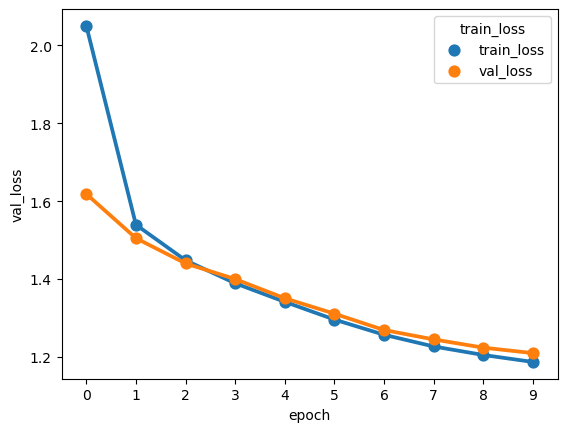

In [22]:
import seaborn
seaborn.pointplot(
    data=loss_epochs_data, x='epoch', y='val_loss', hue='train_loss',)

## Evaluar modelo usando test set

In [23]:
targets = []
predictions = []
for batch in tqdm(test_loader):
    output = model(batch["data"].to(device))
    labels = batch["target"].long().to(device)
    targets.extend(labels.cpu().numpy())
    predictions.extend(output.argmax(axis=1).detach().cpu().numpy())

test_socore = balanced_accuracy_score(targets, predictions)
ba_score_msg = f"balanced_accuracy_score on test set: {test_socore}"
print(ba_score_msg)
mlflow.log_metric('test_balanced_accuracy', test_socore)

  0%|          | 0/498 [00:00<?, ?it/s]

balanced_accuracy_score on test set: 0.7730143992919339
